# Titanic - Machine Learning from Disaster

This is the Version 0. This notebook is a complete mess. I wanted to try all the possible models (Decision Tree, Random Forest,
SVM with all kernel functions, Neural Network).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, LearningCurveDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge

## Explore the dataframe

In [2]:
# Data frame.
df = pd.read_csv('train.csv', sep=',')

# Drop id, name columns.
#df = df.drop(columns=["PassengerId", "Name"], axis=1)
df = df.drop(columns=["PassengerId"], axis=1)

print("Dataset shape =", df.shape)
print(df.describe())

print("\n\nFirst 10 samples in the dataset:\n\n", df.head(10))

Dataset shape = (891, 11)
         Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200


First 10 samples in the dataset:

    Survived  Pclass                                               Name  \
0         0       3                            Braund, Mr. Owen Harris   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         1  

## Features engeniring

In [3]:
print(df[df['Name'].str.contains("Dr.", na=False)])

     Survived  Pclass                                             Name  \
47          1       3                        O'Driscoll, Miss. Bridget   
130         0       3                             Drazenoic, Mr. Jozef   
245         0       1                      Minahan, Dr. William Edward   
317         0       2                             Moraweck, Dr. Ernest   
398         0       2                                 Pain, Dr. Alfred   
416         1       2  Drew, Mrs. James Vivian (Lulu Thorne Christian)   
632         1       1                        Stahelin-Maeglin, Dr. Max   
660         1       1                    Frauenthal, Dr. Henry William   
679         1       1               Cardeza, Mr. Thomas Drake Martinez   
766         0       1                        Brewe, Dr. Arthur Jackson   
796         1       1                      Leader, Dr. Alice (Farnham)   

        Sex   Age  SibSp  Parch    Ticket      Fare        Cabin Embarked  
47   female   NaN      0      0    

We add a new column that indicates the title of each passenger.
This information can be obtained from the name column.
The highest titles are categorized as "High".

In [4]:
# Define a new column called title.
def get_title(name):
    if 'Sir.' in name:
        return 'High'
    elif 'Dr.' in name:
        return 'High'
    elif 'Mr.' in name:
        return 'Mr'
    elif 'Lady' in name:
        return 'High'
    elif 'Countess' in name:
        return 'High'
    elif 'Capt' in name:
        return 'High'
    elif 'Major' in name:
        return 'High'
    elif 'Jonkheer' in name:
        return 'High'
    elif 'Rev' in name:
        return 'High'
    elif 'Col' in name:
        return 'High'
    elif 'Don' in name:
        return 'High'
    elif 'Master' in name:
        return 'Master'
    elif 'Mrs.' in name:
        return 'Mrs'
    elif 'Ms.' in name:
        return 'Mrs'
    elif 'Miss.' in name:
        return 'Miss'
    else:
        return 'N'

title_col = df['Name'].apply(get_title)
print(title_col.value_counts())
df["Title"] = title_col
df = df.drop(columns=['Name'], axis=1)

Name
Mr        517
Miss      181
Mrs       125
Master     40
High       25
N           3
Name: count, dtype: int64


In [5]:
# Define a new column called Mother.
#mother_col = ((df["Age"] >= 25) & (df["Parch"] != 0)).astype(int)
#print(mother_col.value_counts())
#df["Mother"] = mother_col

In [6]:
# Add new column called Alone.
alone_col = ((df["Parch"] == 0) & (df["SibSp"] == 0)).astype(int)
print(alone_col.value_counts())
df["Alone"] = alone_col

1    537
0    354
Name: count, dtype: int64


In [7]:
# Categorize cabin: take the first letter as new cabin value.
def first_cabin_letter(cabin):
    cabin = str(cabin)
    if cabin == "nan":
        return "FakeCabin"
    return cabin[0]

new_cabin_col = df["Cabin"].apply(first_cabin_letter)
print(new_cabin_col.value_counts())
df["Cabin"] = new_cabin_col

Cabin
FakeCabin    687
C             59
B             47
D             33
E             32
A             15
F             13
G              4
T              1
Name: count, dtype: int64


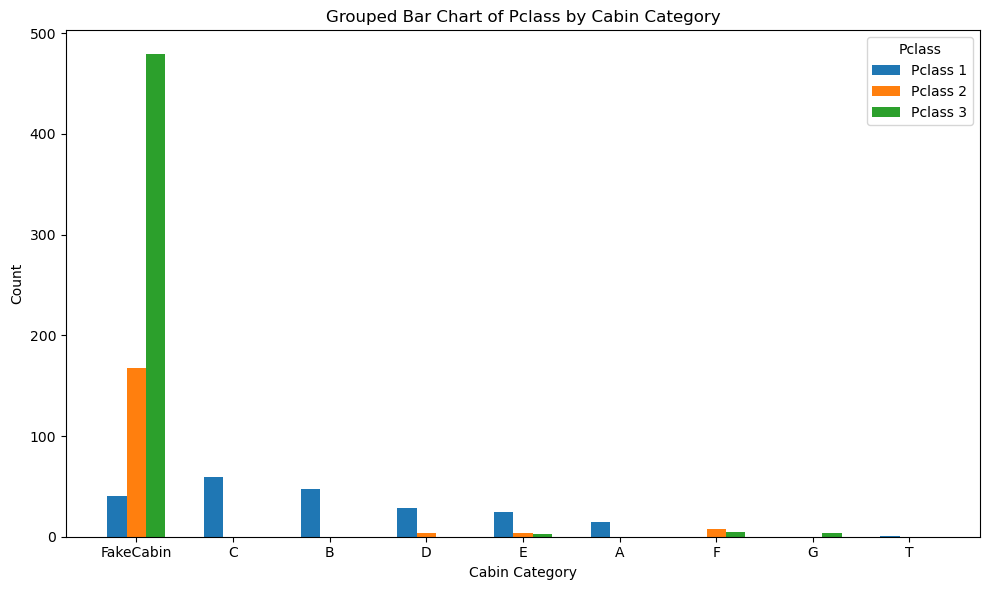

In [8]:
# Print class for each cabin category.
# Categories and classes
category = ['FakeCabin', 'C', 'B', 'D', 'E', 'A', 'F', 'G', 'T']
classes = [1, 2, 3]

# Count occurrences of each class for each cabin category
counts = {cabin: [len(df[(df["Cabin"] == cabin) & (df["Pclass"] == cls)]) for cls in classes] for cabin in category}

# Create a grouped bar chart
bar_width = 0.2
x = np.arange(len(category))  # x positions for the groups

# Plot bars for each class
plt.figure(figsize=(10, 6))
for i, cls in enumerate(classes):
    plt.bar(x + i * bar_width, [counts[cabin][i] for cabin in category], width=bar_width, label=f"Pclass {cls}")

# Add labels, title, and legend
plt.xticks(x + bar_width, category)  # Center group labels
plt.xlabel("Cabin Category")
plt.ylabel("Count")
plt.title("Grouped Bar Chart of Pclass by Cabin Category")
plt.legend(title="Pclass")

# Show the plot
plt.tight_layout()
plt.show()

We have only one passenger in cabin T, this passenger is Pclass 1, so we can add
him in cabin A.

In [9]:
print(df[df["Cabin"] == "T"])
df.loc[df["Cabin"] == "T", "Cabin"] = "A"

     Survived  Pclass   Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  \
339         0       1  male  45.0      0      0  113784  35.5     T        S   

    Title  Alone  
339    Mr      1  


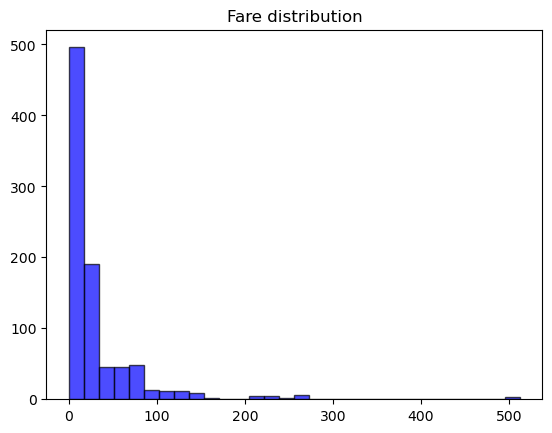

In [10]:
# Print Fare distribution.
plt.hist(df["Fare"].tolist(), bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Fare distribution")
plt.show()

We have some outliers that have a value grater than 500.
Try to change their value to the second highest value.

In [11]:
print(df[df["Fare"] >= 500])
df.loc[df["Fare"] >= 500, "Fare"] = 250

     Survived  Pclass     Sex   Age  SibSp  Parch    Ticket      Fare  \
258         1       1  female  35.0      0      0  PC 17755  512.3292   
679         1       1    male  36.0      0      1  PC 17755  512.3292   
737         1       1    male  35.0      0      0  PC 17755  512.3292   

         Cabin Embarked Title  Alone  
258  FakeCabin        C  Miss      1  
679          B        C    Mr      0  
737          B        C    Mr      1  


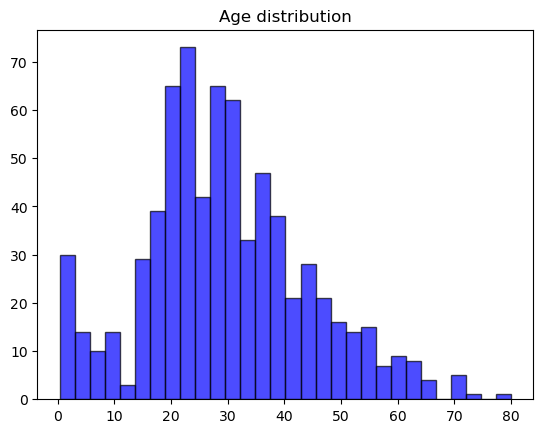

In [12]:
# Print Age distribution.
plt.hist(df["Age"].dropna().tolist(), bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Age distribution")
plt.show()

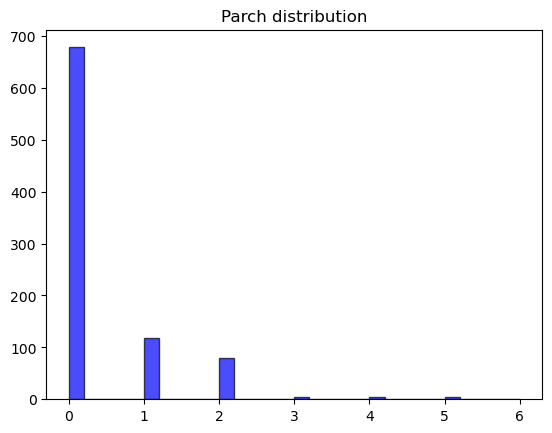

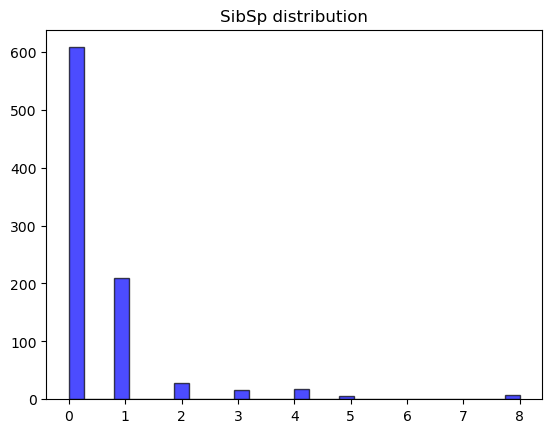

In [13]:
# Print Parch distribution and SibSp distribution.
plt.hist(df["Parch"].tolist(), bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Parch distribution")
plt.show()

plt.hist(df["SibSp"].tolist(), bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("SibSp distribution")
plt.show()

We can try to add a new feature called FamilySize in which we sum the value of Parch and SibSp
column.

In [14]:
# Add new column called FamilySize.
df["FamilySize"] = df["Parch"] + df["SibSp"]
# Drop Parch and SibSp.
df = df.drop(columns=["Parch", "SibSp"], axis=1)

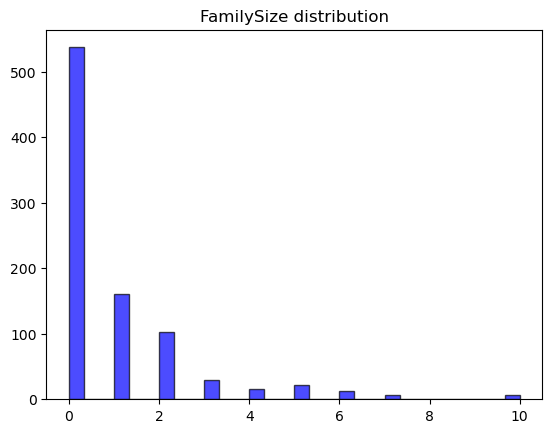

In [15]:
# Print FamilySize distribution.
plt.hist(df["FamilySize"].tolist(), bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("FamilySize distribution")
plt.show()

## Which feature should we keep/which one should we remove?

In [16]:
# Drop the cabin clumn: too many missing values.
#print("Tot missing cabin info:", df['Cabin'].isna().sum())
#df = df.drop(columns=["Cabin"], axis=1)

In [17]:
# Drop the ticket.
print("Tot missing ticket info:", df['Ticket'].isna().sum())
df = df.drop(columns=["Ticket"], axis=1)

Tot missing ticket info: 0


In [18]:
# Missing values.
print("Missing values for each column\n")
print(df.isna().sum())

Missing values for each column

Survived        0
Pclass          0
Sex             0
Age           177
Fare            0
Cabin           0
Embarked        2
Title           0
Alone           0
FamilySize      0
dtype: int64


In [19]:
# Fill missing Embarked values with 'S'.
df['Embarked'] = df ['Embarked'].fillna('S')

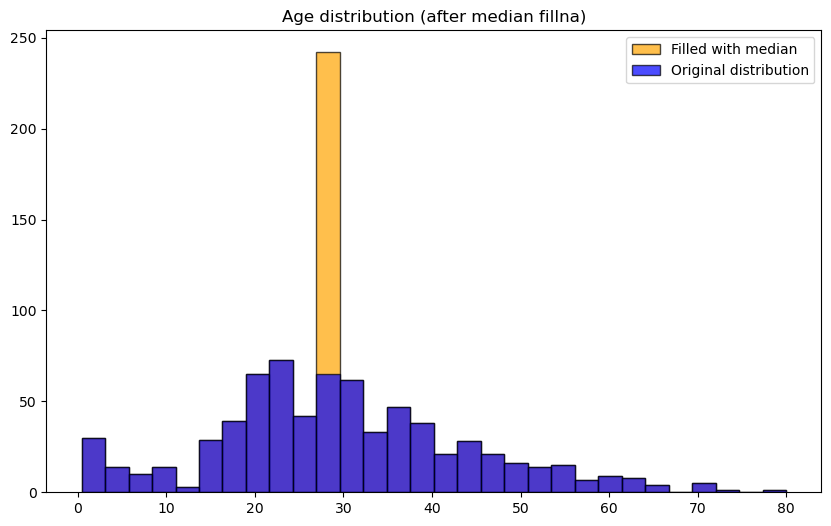

In [20]:
# Fill missing ages with the median value.
median_age_col = df['Age'].fillna(df['Age'].median())
# Print the distribution.
plt.figure(figsize=(10, 6))
plt.hist(median_age_col.tolist(), bins=30, color='orange', alpha=0.7, edgecolor='black', label="Filled with median")
plt.hist(df["Age"].dropna().tolist(), bins=30, color='blue', alpha=0.7, edgecolor='black', label="Original distribution")
plt.title("Age distribution (after median fillna)")
plt.legend()
plt.show()

In [21]:
# Or else we can just use regression to estimate the missing age.

# Define X and Y sets.
X = df.dropna().drop(columns=["Age", "Survived"], axis=1)
Y = df["Age"].dropna()

print("Features names:", list(X.columns))

# Split the data.
m = X.shape[0]
m_train = int(3./5. * m)
m_val = int((m - m_train) / 2.)
m_test = m - m_train - m_val
print("Tot number of samples:", X.shape[0])

X = X.values
Y = Y.values

# Preprocessing
# Sex and Embarked columns need to be encoded.
to_encode = [1, 3, 4, 5] 

# Define the encode and encode the specified columns.
enc = OrdinalEncoder()
X[:, to_encode] = enc.fit_transform(X[:, to_encode])

# Transform all samples into vector of folat values.
X = np.array(X, dtype=np.float32)

# Split into train_val and test.
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=m_test/m, random_state=12)

# Split into train and val.
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=m_val/(m_train + m_val), random_state=12)

# Check size of sets.
print("\nTraining size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Training and validation size:", X_train_val.shape[0])
print("Test size:", X_test.shape[0])

# Fare column need to be scaled.
to_scale = [2]

# Create a copy for each set.
X_train_scaled = np.copy(X_train)
X_test_scaled = np.copy(X_test)
X_val_scaled = np.copy(X_val)
X_train_val_scaled = np.copy(X_train_val)

# Scale data.
scaler_age = StandardScaler().fit(X_train[:, to_scale])
X_train_scaled[:, to_scale] = scaler_age.transform(X_train[:, to_scale])
X_test_scaled[:, to_scale] = scaler_age.transform(X_test[:, to_scale])
X_val_scaled[:, to_scale] = scaler_age.transform(X_val[:, to_scale])
X_train_val_scaled[:, to_scale] = scaler_age.transform(X_train_val[:, to_scale])

Features names: ['Pclass', 'Sex', 'Fare', 'Cabin', 'Embarked', 'Title', 'Alone', 'FamilySize']
Tot number of samples: 714

Training size: 428
Validation size: 143
Training and validation size: 571
Test size: 143


Training error: 0.4725373913162023
Optimal Params {'max_depth': np.int64(5), 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 12}


RandomForestRegressor(max_depth=np.int64(5), min_samples_leaf=2,
                      random_state=12)

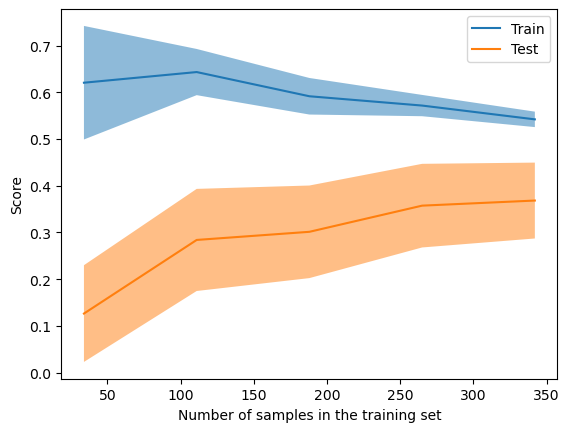

In [22]:
# Best random forest model for predicting the age.
param_grid = {
    "max_depth": np.arange(1, 31, 1),
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3],
    "random_state": [12]
}
gs = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
gs.fit(X_train_scaled, Y_train)
print("Training error:", 1 - gs.score(X_train_scaled, Y_train))
print("Optimal Params", gs.best_params_)
LearningCurveDisplay.from_estimator(gs.best_estimator_, X_train_scaled, Y_train)
rf = RandomForestRegressor(**gs.best_params_)
rf.fit(X_train_scaled, Y_train)

Training error: 0.6278351193435683
Optimal Params {'max_depth': np.int64(3), 'min_samples_leaf': 3, 'min_samples_split': 2, 'random_state': 12}


DecisionTreeRegressor(max_depth=np.int64(3), min_samples_leaf=3,
                      random_state=12)

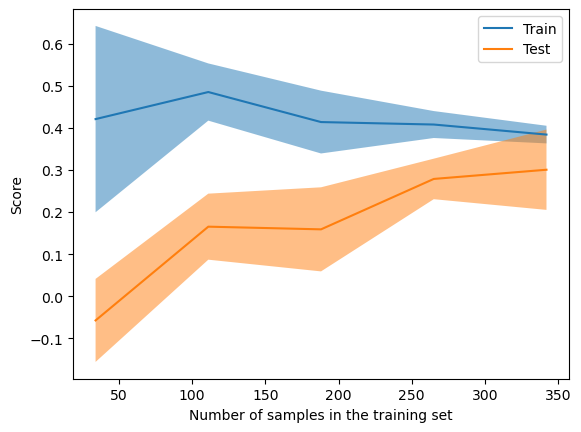

In [23]:
# Best decision tree model for predicting the age.
param_grid = {
    "max_depth": np.arange(1, 31, 1),
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3],
    "random_state": [12]
}
gs = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5)
gs.fit(X_train_scaled, Y_train)
print("Training error:", 1 - gs.score(X_train_scaled, Y_train))
print("Optimal Params", gs.best_params_)
LearningCurveDisplay.from_estimator(gs.best_estimator_, X_train_scaled, Y_train)
dt = DecisionTreeRegressor(**gs.best_params_)
dt.fit(X_train_scaled, Y_train)

In [24]:
# Best svm for predicting the age.
param_grid = [
    {"kernel": ["rbf"], "gamma": [0.01, 0.03, 0.06, 0.1, 0.12], "C": [0.1, 1, 10, 100, 1000], "epsilon": [0.1, 1, 10, 100]},
    {"kernel": ["poly"], "degree": [2, 4, 5], "C": [0.1, 1, 10, 100, 1000], "epsilon": [0.1, 1, 10, 100], "coef0": [0, 1]},
    {"kernel": ["sigmoid"], "gamma": [0.01, 0.03, 0.06, 0.1, 0.12], "C": [0.1, 1, 10, 100, 1000], "epsilon": [0.1, 1, 10, 100], "coef0": [0, 1]},
]
gs = GridSearchCV(SVR(), param_grid, cv=5)
gs.fit(X_train_scaled, Y_train)
print("Training error:", 1 - gs.score(X_train_scaled, Y_train))
print("Optimal Params", gs.best_params_)
svr = SVR(**gs.best_params_)
svr.fit(X_train_scaled, Y_train)

Training error: 0.5879977884197417
Optimal Params {'C': 10, 'epsilon': 10, 'gamma': 0.12, 'kernel': 'rbf'}


SVR(C=10, epsilon=10, gamma=0.12)

In [25]:
# Ridge regression model for predicting the ages.
param_grid = {
    "alpha": np.arange(1, 100, 1)
}
gs = GridSearchCV(Ridge(), param_grid, cv = 5)
gs.fit(X_train_scaled, Y_train)
print("Training error:", 1 - gs.score(X_train_scaled, Y_train))
print("Optimal Params", gs.best_params_)
ridge = Ridge(**gs.best_params_)
ridge.fit(X_train_scaled, Y_train)

Training error: 0.7145621862580138
Optimal Params {'alpha': np.int64(7)}


Ridge(alpha=np.int64(7))

In [26]:
# Decide the predictor using the validation data.
val_errors = {}

val_errors["dt"] = 1 - dt.score(X_val_scaled, Y_val)
print("Validation error dt:", val_errors["dt"])

val_errors["rf"] = 1 - rf.score(X_val_scaled, Y_val)
print("Validation error rf:", val_errors["rf"])

val_errors["svr"] = 1 - svr.score(X_val_scaled, Y_val)
print("Validation error svr:", val_errors["svr"])

val_errors["ridge"] = 1 - ridge.score(X_val_scaled, Y_val)
print("Validation error ridge:", val_errors["ridge"])

age_pred_name = min(val_errors, key=val_errors.get)
print("\nBest model:", age_pred_name)

Validation error dt: 0.6581815763748273
Validation error rf: 0.6626719796483664
Validation error svr: 0.6742041269798424
Validation error ridge: 0.7399591031029619

Best model: dt


In [27]:
# Final age predictor.
age_predictor = None
if age_pred_name == "dt":
    age_predictor = dt 
elif age_pred_name == "rf":
    age_predictor = rf
elif age_pred_name == "svr":
    age_predictor = svr 
elif age_pred_name == "ridge":
    age_predictor = ridge

age_predictor.fit(X_train_val_scaled, Y_train_val)
print("Final age predictor test error", 1 - age_predictor.score(X_test_scaled, Y_test))

Final age predictor test error 0.5649874282403003


In [28]:
# Predict the missing value of Age column.
to_predict = df[df["Age"].isna()].drop(columns=["Age","Survived"], axis=1)
to_predict = to_predict.values

to_predict[:, to_encode] = enc.fit_transform(to_predict[:, to_encode])
to_predict[:, to_scale] = scaler_age.transform(to_predict[:, to_scale])

missing_age = age_predictor.predict(to_predict)

nan_indices = df.index[df['Age'].isna()].tolist()
replacement_dict = dict(zip(nan_indices, missing_age))

dt_age_col = df['Age'].fillna(pd.Series(replacement_dict))

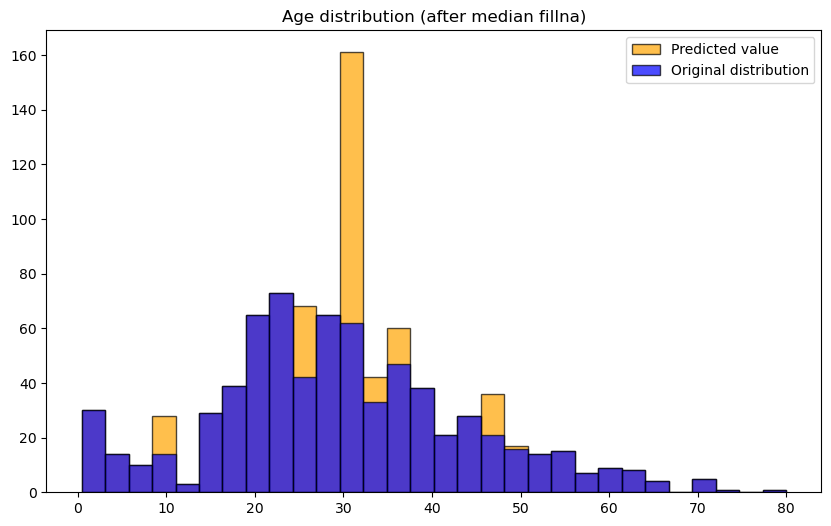

In [29]:
# Print the distribution.
plt.figure(figsize=(10, 6))
plt.hist(dt_age_col.tolist(), bins=30, color='orange', alpha=0.7, edgecolor='black', label="Predicted value")
plt.hist(df["Age"].dropna().tolist(), bins=30, color='blue', alpha=0.7, edgecolor='black', label="Original distribution")
plt.title("Age distribution (after median fillna)")
plt.legend()
plt.show()

In [30]:
# Fill missing Age with dt prediction.
df["Age"] = dt_age_col

In [31]:
# Define X and Y sets.
X = df.drop(columns=["Survived"], axis=1)
Y = df["Survived"]

print("Tot number of samples:", X.shape[0])
features_names = list(X.columns)
print("Features names:", features_names)

X = X.values
Y = Y.values
print("X shape:", X.shape)
print("Y shape:", Y.shape)

Tot number of samples: 891
Features names: ['Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked', 'Title', 'Alone', 'FamilySize']
X shape: (891, 9)
Y shape: (891,)


## Encode categorical variable

In [32]:
# Print the data type of each column.
for index_col, name_col in zip(range(X.shape[1]), features_names):
    print(f"Column {name_col} (index: {index_col}) -- data type: {type(X[0, index_col])}")

Column Pclass (index: 0) -- data type: <class 'int'>
Column Sex (index: 1) -- data type: <class 'str'>
Column Age (index: 2) -- data type: <class 'float'>
Column Fare (index: 3) -- data type: <class 'float'>
Column Cabin (index: 4) -- data type: <class 'str'>
Column Embarked (index: 5) -- data type: <class 'str'>
Column Title (index: 6) -- data type: <class 'str'>
Column Alone (index: 7) -- data type: <class 'int'>
Column FamilySize (index: 8) -- data type: <class 'int'>


In [33]:
# Encode the categorical variables.
# Sex and Embarked columns need to be encoded.
to_encode = [1, 4, 5, 6] 

# Define the encode and encode the specified columns.
enc = OrdinalEncoder()
X[:, to_encode] = enc.fit_transform(X[:, to_encode])

In [34]:
# Print the data type of each column.
for index_col, name_col in zip(range(X.shape[1]), features_names):
    print(f"Column {name_col} (index: {index_col}) -- data type: {type(X[0, index_col])}")

Column Pclass (index: 0) -- data type: <class 'int'>
Column Sex (index: 1) -- data type: <class 'float'>
Column Age (index: 2) -- data type: <class 'float'>
Column Fare (index: 3) -- data type: <class 'float'>
Column Cabin (index: 4) -- data type: <class 'float'>
Column Embarked (index: 5) -- data type: <class 'float'>
Column Title (index: 6) -- data type: <class 'float'>
Column Alone (index: 7) -- data type: <class 'int'>
Column FamilySize (index: 8) -- data type: <class 'int'>


## Split data into train/validation and test

In [35]:
# Split data.
m = X.shape[0]
m_train = int(3./5. * m)
m_val = int((m - m_train) / 2.)
m_test = m - m_train - m_val

print("Amount of data for training set:", m_train)
print("Amount of data for validation set", m_val)
print("Amount of data for test set:", m_test)

Amount of data for training set: 534
Amount of data for validation set 178
Amount of data for test set: 179


In [36]:
# Transform all samples into vector of folat values.
X = np.array(X, dtype=np.float32)

# Split into train_val and test.
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=m_test/m, random_state=12)

# Split into train and val.
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=m_val/(m_train + m_val), random_state=12)

# Check size of sets.
print("Training size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Training and validation size:", X_train_val.shape[0])
print("Test size:", X_test.shape[0])

Training size: 534
Validation size: 178
Training and validation size: 712
Test size: 179


## Data Standardization

In [37]:
# Fare column need to be scaled.
to_scale = [3]

# Create a copy for each set.
X_train_scaled = np.copy(X_train)
X_test_scaled = np.copy(X_test)
X_val_scaled = np.copy(X_val)
X_train_val_scaled = np.copy(X_train_val)

# Scale data.
scaler = StandardScaler().fit(X_train[:, to_scale])
X_train_scaled[:, to_scale] = scaler.transform(X_train[:, to_scale])
X_test_scaled[:, to_scale] = scaler.transform(X_test[:, to_scale])
X_val_scaled[:, to_scale] = scaler.transform(X_val[:, to_scale])
X_train_val_scaled[:, to_scale] = scaler.transform(X_train_val[:, to_scale])

In [38]:
from sklearn.model_selection import KFold
from itertools import product

def k_fold_cross_validation(X, Y, model_func, num_folds = 10, verbose=False, **param_grid):

    # -- grid of hyperparams into list
    param_keys = list(param_grid.keys())
    param_values = list(param_grid.values())
    
    # Generate Cartesian product of values
    combinations = product(*param_values)
    
    # Create a list of dictionaries from combinations
    param_list = [dict(zip(param_keys, combination)) for combination in combinations]

    kf = KFold(n_splits = num_folds)
    
    err_validation_kfold = np.zeros(len(param_list),)
    err_training_kfold = np.zeros(len(param_list),)

    for i, params in enumerate(param_list):

        model = model_func(**params)
        
        for train_index, validation_index in kf.split(X):
            X_train_kfold, X_val_kfold = X[train_index], X[validation_index]
            Y_train_kfold, Y_val_kfold = Y[train_index], Y[validation_index]
            
            # -- data scaling: standardize features with respect to the current folds
            scaler_kfold = StandardScaler().fit(X_train_kfold)
            X_train_kfold_scaled = scaler_kfold.transform(X_train_kfold)
            X_val_kfold_scaled = scaler_kfold.transform(X_val_kfold)
        
            # -- learn the model using the training data from the k-fold
            model.fit(X_train_kfold_scaled, Y_train_kfold)
            
            # -- incremental mean
            err_training_kfold[i] += (1.0 - model.score(X_train_kfold_scaled, Y_train_kfold))
            err_validation_kfold[i] += (1.0 - model.score(X_val_kfold_scaled, Y_val_kfold))

    
    # -- compute the mean
    err_training_kfold /= num_folds
    err_validation_kfold /= num_folds
    
    # -- choose the best paramter: the one that minimizes the (the estimation of the true) loss
    best_param = param_list[np.argmin(err_validation_kfold)]

    if verbose:
        print("Optimal paramters:", best_param)
        print("Min validation error", np.min(err_validation_kfold))
    
    return best_param, err_training_kfold, err_validation_kfold

In [39]:
def plot_model_selection_curve(x, err_train, err_val, opt_x, xlabel=None, title=None):
    # Plot the training error.
    plt.plot(x, err_train,  color='r', marker='x', label="Train")
    # Plot the validation error.
    plt.plot(x, err_val,  color='b',  marker='x', label="Validation")
    # Optimal point.
    if xlabel:
        plt.scatter(opt_x,  np.min(err_val),  color='b',  marker='o',  linewidths=5, label=f"{xlabel} opt={opt_x}")
    else:
        plt.scatter(opt_x,  np.min(err_val),  color='b',  marker='o',  linewidths=5)
    plt.legend()
    if xlabel:
        plt.xlabel(xlabel)
    plt.ylabel("Error")
    if title:
        plt.title(title)
    plt.show()

## Define the function that implement the k-cross fold validation

## Train best decision tree model

Optimal paramters: {'max_depth': 6, 'random_state': 12}
Min validation error 0.16663172606568832


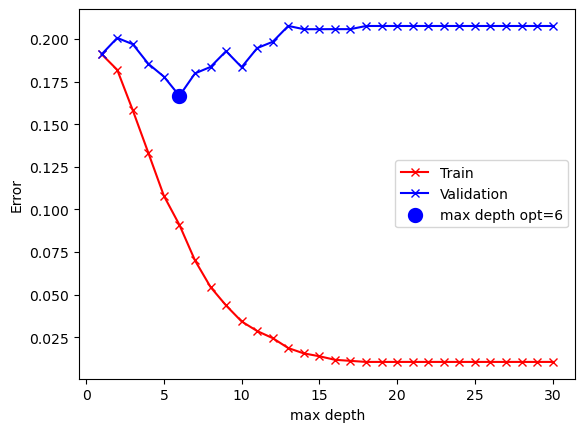

In [40]:
from sklearn.tree import DecisionTreeClassifier

params = {
    "max_depth": [v for v in range(1, 31)],
    "random_state": [12]
}
opt_params, err_train, err_val = k_fold_cross_validation(
    X_train_scaled,
    Y_train,
    model_func=DecisionTreeClassifier,
    verbose=True,
    **params
)
plot_model_selection_curve(
    params["max_depth"],
    err_train,
    err_val,
    opt_params["max_depth"],
    xlabel="max depth"
)

In [41]:
# Final model for decision tree.
final_decision_tree = DecisionTreeClassifier(**opt_params)
final_decision_tree.fit(X_train_scaled, Y_train)
print("Training error:", 1 - final_decision_tree.score(X_train_scaled, Y_train))

Training error: 0.09363295880149813


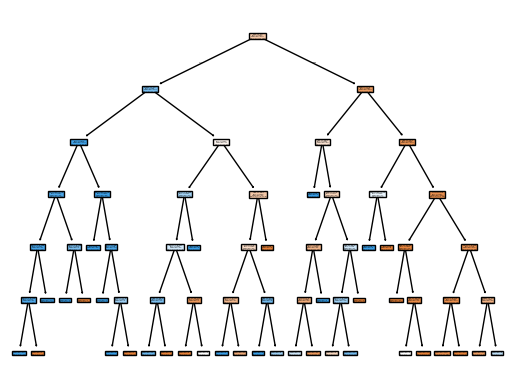

In [42]:
# Plot the tree of the final model.
from sklearn import tree

plt.figure()
tree.plot_tree(decision_tree=final_decision_tree,
               feature_names=features_names, 
               filled=True)
plt.savefig("tree.pdf")
plt.show()

In [43]:
# Print features importance.
print([f"{x} = {str(y)}" for x,y in zip(features_names, final_decision_tree.feature_importances_)])

['Pclass = 0.12482520336717892', 'Sex = 0.49502035704750336', 'Age = 0.09706030994813304', 'Fare = 0.09785121386499603', 'Cabin = 0.08050482653238875', 'Embarked = 0.01816762340918742', 'Title = 0.030124039469598816', 'Alone = 0.0034781603296607055', 'FamilySize = 0.05296826603135302']


## Train best random forset model

Optimal paramters: {'max_depth': 6, 'random_state': 12}
Min validation error 0.14598183088749123


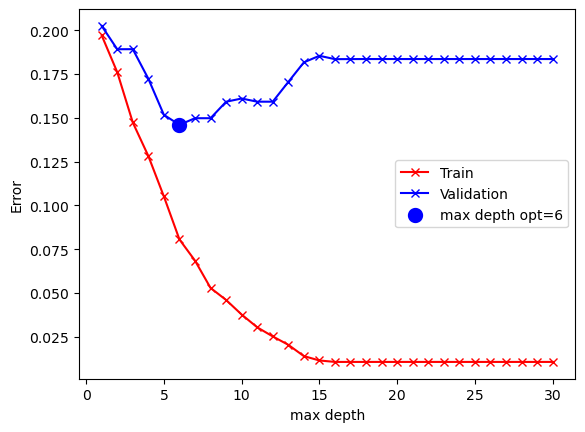

In [45]:
from sklearn.ensemble import RandomForestClassifier

# Find best value for max depth.
params = {
    "max_depth": [v for v in range(1, 31)], 
    "random_state": [12]
}
opt_params, err_train, err_val = k_fold_cross_validation(
    X_train_scaled, Y_train, 
    model_func=RandomForestClassifier,
    verbose=True,
    **params
)
plot_model_selection_curve(
    params["max_depth"], 
    err_train,
    err_val,
    opt_params["max_depth"],
    xlabel="max depth",
)

In [46]:
# Final model for random forest.
final_random_forest = RandomForestClassifier(**opt_params)
final_random_forest.fit(X_train_scaled, Y_train)
print("Training error:", 1 - final_random_forest.score(X_train_scaled, Y_train))

Training error: 0.0842696629213483


## Train best model for SVM model: best model for different kernel functions

Optimal paramters: {'C': 1, 'kernel': 'linear', 'random_state': 12}
Min validation error 0.1910202655485674


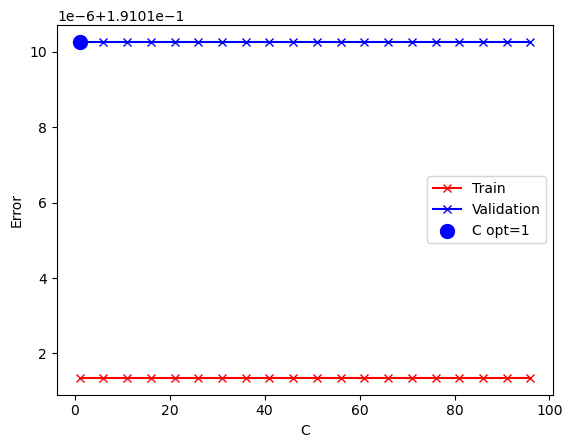

In [47]:
# Find the best SVM with linear kernel.
from sklearn.svm import SVC

params = {
    "C": np.arange(1, 100, 5).tolist(),
    "kernel": ["linear"],
    "random_state": [12]
}
opt_params, err_train, err_val = k_fold_cross_validation(
    X_train_scaled,
    Y_train,
    model_func=SVC,
    verbose=True,
    **params
)
plot_model_selection_curve(
    params["C"],
    err_train,
    err_val,
    opt_params["C"],
    xlabel="C"
)

Mmmh we're not learning anything... with linear kernel.

In [48]:
# Final model for lin svm.
final_lin_svm = SVC(**opt_params)
final_lin_svm.fit(X_train_scaled, Y_train)
print("Training error:", 1 - final_lin_svm.score(X_train_scaled, Y_train))

Training error: 0.1910112359550562


In [49]:
# Train best rbf.
params = {
    "C": np.arange(1, 100, 5).tolist(),
    "kernel": ["rbf"],
    "gamma": [0.01, 0.03, 0.04, 0.05],
    "random_state": [12]
}
opt_params, err_train, err_val = k_fold_cross_validation(
    X_train_scaled,
    Y_train,
    model_func=SVC,
    verbose=True,
    **params
)

Optimal paramters: {'C': 76, 'kernel': 'rbf', 'gamma': 0.04, 'random_state': 12}
Min validation error 0.15352900069881198


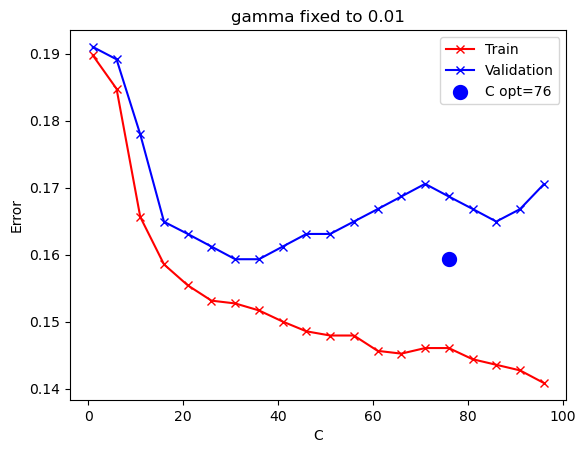

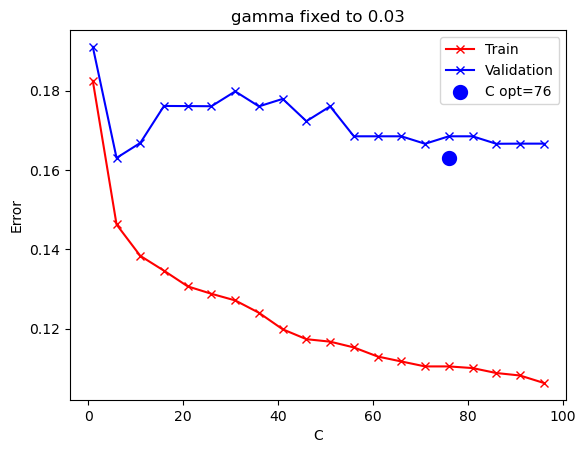

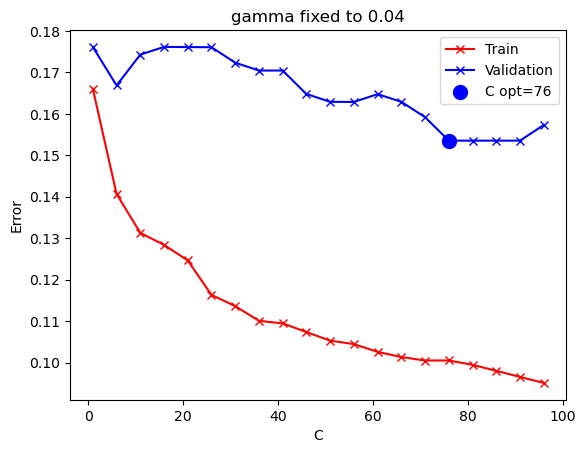

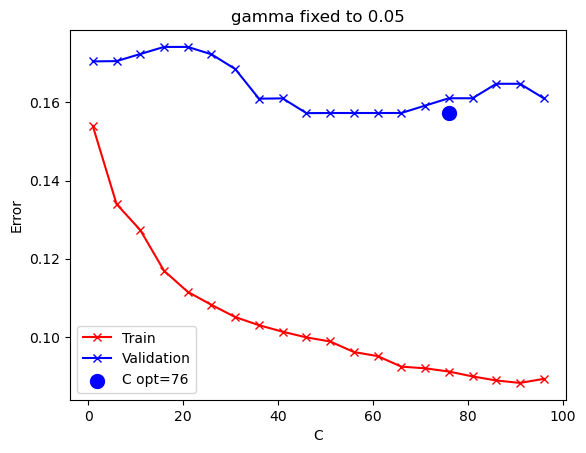

In [50]:
# Plot relation between C and different values of gamma.
z = ["gamma", [0.01, 0.03, 0.04, 0.05]]
jump = len(z[1])

# Grid of hyperparams into list
param_keys = list(params.keys())
param_values = list(params.values())

# Generate Cartesian product of values
combinations = product(*param_values)
param_list = [dict(zip(param_keys, combination)) for combination in combinations]

plt.figure()
for i in range(jump):
    C_vals = [x["C"] for x in param_list]

    plot_model_selection_curve(
        C_vals[i::jump],
        err_train[i::jump],
        err_val[i::jump],
        opt_params["C"],
        title=f"{z[0]} fixed to {z[1][i]}",
        xlabel="C"
    )

In [51]:
# Final model for rbf svm.
final_rbf_svm = SVC(**opt_params)
final_rbf_svm.fit(X_train_scaled, Y_train)
print("Training error:", 1 - final_rbf_svm.score(X_train_scaled, Y_train))

Training error: 0.06367041198501877


In [52]:
# Learn best model for sigmoid.
params = {
    "C": np.arange(1, 100, 5).tolist(),
    "kernel": ["sigmoid"],
    "gamma": [0.01, 0.03, 0.04, 0.05],
    "coef0": np.arange(0, 5, 1).tolist(),
    "random_state": [12]
}
opt_params, err_train, err_val = k_fold_cross_validation(
    X_train_scaled,
    Y_train,
    model_func=SVC,
    verbose=True,
    **params
)

Optimal paramters: {'C': 36, 'kernel': 'sigmoid', 'gamma': 0.01, 'coef0': 3, 'random_state': 12}
Min validation error 0.18169112508735147


In [53]:
# Train best model for sigmoid kernel.
final_sig_svm = SVC(**opt_params)
final_sig_svm.fit(X_train_scaled, Y_train)
print("Training error:", 1 - final_sig_svm.score(X_train_scaled, Y_train))

Training error: 0.36329588014981273


In [54]:
# Best params for poly kernel.
params = {
    "C": np.arange(1, 100, 5).tolist(),
    "kernel": ["poly"],
    "degree": [2, 3, 4],
    "gamma": [0.01, 0.03, 0.04, 0.05],
    "coef0": np.arange(0, 1, 1).tolist(),
    "random_state": [12]
}
opt_params, err_train, err_val = k_fold_cross_validation(
    X_train_scaled,
    Y_train,
    model_func=SVC,
    verbose=True,
    **params
)

Optimal paramters: {'C': 46, 'kernel': 'poly', 'degree': 3, 'gamma': 0.04, 'coef0': 0, 'random_state': 12}
Min validation error 0.16858839972047518


In [55]:
# Train best model for poly kernel.
#final_poly_svm = SVC(**opt_params)
final_poly_svm = SVC()
final_poly_svm.fit(X_train_scaled, Y_train)
print("Training error:", 1 - final_poly_svm.score(X_train_scaled, Y_train))

Training error: 0.28464419475655434


## Train best Deep Neural Network model

Just for fun...

In [56]:
# We are going to use pytorch.
import torch
import torch.nn as nn

In [57]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print("device:", device)

In [58]:
# We need this wrapper because we cannot use directly 
# the trainin set X creted with scikitlearn.
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.features = X
        self.labels = Y
        
    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        labels = torch.tensor(self.labels[idx], dtype=torch.float32)
        return features, labels

In [59]:
# Define a simple NN.
class NN(nn.Module):

    # Need the following for the kfold func compatibility.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def __init__(self, layers):
        super(NN, self).__init__()
        torch.manual_seed(12)

        # Define the structure.
        self.layers = nn.ModuleList()
        for i in range(1, len(layers)):
            self.layers.append(nn.Linear(layers[i-1], layers[i]))
        self.layers.append(nn.Linear(layers[-1], 1)) # Last layer
        
        # Acivaction function.
        self.actfunc = nn.ReLU() 

        # Need the following for the kfold func compatibility.
        self.to(NN.device)

    def forward(self, x):
        out = x
        for i, layer in enumerate(self.layers):
            out = layer(out)
            if i < len(self.layers) - 1:
                out = self.actfunc(out)
        out = torch.sigmoid(out)
        return out
        

    def fit(self, X, Y, epochs=10):
        # Crate dataset and dataloader.
        train_ds= MyDataset(X, Y)
        train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=1, shuffle=True)

        # Function cost.
        cost = nn.BCELoss()
        # Optimizier used.
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

        # Train the model.
        for _ in range(epochs):
            for i, (x, y) in enumerate(train_loader):
                x = x.to(NN.device)
                y = y.to(NN.device)
        
                # Forward pass: make the prediction.
                outputs = self(x).squeeze(1) # Get predictions.
        
                loss = cost(outputs, y) # Compute the costs.
        
                # Backward and optimize
                optimizer.zero_grad() # Compute the gradient for current batch.
                loss.backward() # Compute back propagation (sensitivity vec)
                optimizer.step() # Update the weights.

    
    def score(self, X, Y):
        # Crate dataset and dataloader.
        train_ds= MyDataset(X, Y)
        train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=1, shuffle=True)
        
        with torch.no_grad(): # Do not compute gradients.
            correct = 0
            total = 0
            for x, y in train_loader:
                # Move data to GPU.
                x = x.to(NN.device)
                y = y.to(NN.device)
        
                # Predict output.
                outputs = self(x).squeeze(1)
                outputs = (outputs >= 0.5).float()
                
                # Check if prediction is correct.
                total += y.size(0)
                correct += (outputs == y).sum().item()
            return correct / total

In [60]:
# Define input size (number of features).
input_size = len(features_names)

# Stucture of the NN is:
# 3 hidden layers with 4 neurons each.
structure = [input_size, 4, 4, 4]
layers = {"layers": structure}

# Create model.
nn_model = NN(**layers)
print("Model structure:")
print(nn_model)

Model structure:
NN(
  (layers): ModuleList(
    (0): Linear(in_features=9, out_features=4, bias=True)
    (1-2): 2 x Linear(in_features=4, out_features=4, bias=True)
    (3): Linear(in_features=4, out_features=1, bias=True)
  )
  (actfunc): ReLU()
)


In [61]:
nn_model.fit(X_train_scaled, Y_train)
print("Training error:", 1 - nn_model.score(X_train_scaled, Y_train))
print("Validation error:", 1 - nn_model.score(X_val_scaled, Y_val))

Training error: 0.2528089887640449
Validation error: 0.3089887640449438


Optimal paramters: {'layers': [9, 14]}
Min validation error 0.1441299790356394


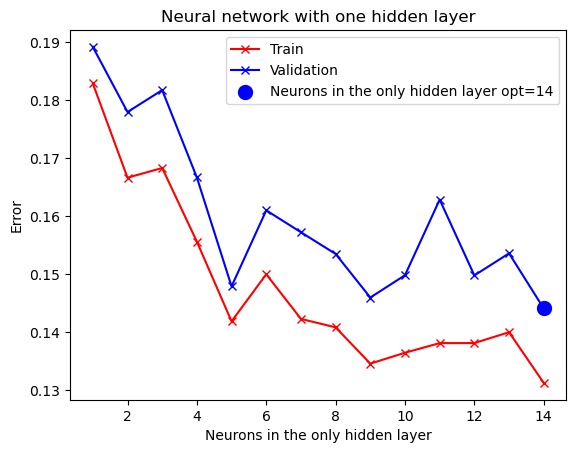

In [62]:
params = {
    "layers": [[input_size, x] for x in range(1, 15)]
}
opt_params, err_train, err_val = k_fold_cross_validation(
    X_train_scaled,
    Y_train,
    model_func=NN,
    verbose=True,
    **params
)
plot_model_selection_curve(
    range(1, len(params["layers"]) + 1),
    err_train,
    err_val,
    opt_params["layers"][1],
    xlabel="Neurons in the only hidden layer",
    title="Neural network with one hidden layer"
)

In [63]:
# Final model for NN with only one hidden layer.
final_nn_1h = NN(**opt_params)
final_nn_1h.fit(X_train_scaled, Y_train, epochs=50)
print("Training error:", 1 - final_nn_1h.score(X_train_scaled, Y_train))

Training error: 0.1629213483146067


Optimal paramters: {'layers': [9, 14, 14, 14]}
Min validation error 0.12907058001397623


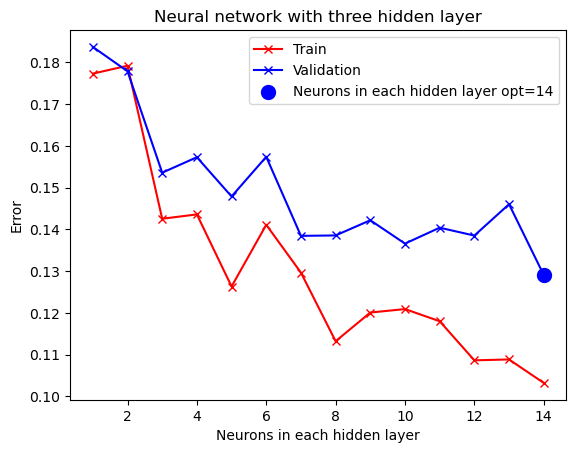

In [64]:
# Neural network with 3 hidden layers.
params = {
    "layers": [[input_size, x, x, x] for x in range(1, 15)]
}
opt_params, err_train, err_val = k_fold_cross_validation(
    X_train_scaled,
    Y_train,
    model_func=NN,
    verbose=True,
    **params
)
plot_model_selection_curve(
    range(1, len(params["layers"]) + 1),
    err_train,
    err_val,
    opt_params["layers"][1],
    xlabel="Neurons in each hidden layer",
    title="Neural network with three hidden layer"
)

In [65]:
# Final model for NN with 3 hidden layer (with same size).
final_nn_3h = NN(**opt_params)
final_nn_3h.fit(X_train_scaled, Y_train, epochs=50)
print("Training error:", 1 - final_nn_3h.score(X_train_scaled, Y_train))

Training error: 0.14981273408239704


## Compare final models using validation set

In [66]:
val_errors = {}

val_errors["decision tree"] = 1 - final_decision_tree.score(X_val_scaled, Y_val)
print("Validation error decision tree:", val_errors["decision tree"])

val_errors["random forest"] = 1 - final_random_forest.score(X_val_scaled, Y_val)
print("Validation error random forest:", val_errors["random forest"])

val_errors["lin svm"] = 1 - final_lin_svm.score(X_val_scaled, Y_val)
print("Validation error linear svm:", val_errors["lin svm"])

val_errors["rbf svm"] = 1 - final_rbf_svm.score(X_val_scaled, Y_val)
print("Validation error rbf svm:", val_errors["rbf svm"])

val_errors["sig svm"] = 1 - final_sig_svm.score(X_val_scaled, Y_val)
print("Validation error sigmoid svm:", val_errors["sig svm"])

val_errors["poly svm"] = 1 - final_poly_svm.score(X_val_scaled, Y_val)
print("Validation error poly svm", val_errors["poly svm"])

val_errors["nn 1h"] = 1 - final_nn_1h.score(X_val_scaled, Y_val)
print("Validation error nn 1h", val_errors["nn 1h"])

val_errors["nn 3h"] = 1 - final_nn_3h.score(X_val_scaled, Y_val)
print("Validation error nn 3h", val_errors["nn 3h"])

best_model_name = min(val_errors, key=val_errors.get)
print("\nBest model:", best_model_name)

Validation error decision tree: 0.1797752808988764
Validation error random forest: 0.1685393258426966
Validation error linear svm: 0.2415730337078652
Validation error rbf svm: 0.2078651685393258
Validation error sigmoid svm: 0.3876404494382022
Validation error poly svm 0.3370786516853933
Validation error nn 1h 0.2078651685393258
Validation error nn 3h 0.2191011235955056

Best model: random forest


## Final best model

In [67]:
final_model = None
if best_model_name == "decision tree":
    final_model = final_decision_tree
elif best_model_name == "random forest":
    final_model = final_random_forest
elif best_model_name == "rbf svm":
    final_model = final_rbf_svm
elif best_model_name == "sig svm":
    final_model = final_sig_svm
elif best_model_name == "lin svm":
    final_model = final_lin_svm
elif best_model_name == "poly svm":
    final_model = final_poly_svm
elif best_model_name == "nn 1h":
    final_model = final_nn_1h
elif best_model_name == "nn 3h":
    final_model = final_nn_3h

print(best_model_name)
final_model.fit(X_train_val_scaled, Y_train_val)
print("Test error:", 1 - final_model.score(X_test_scaled, Y_test))

random forest
Test error: 0.22905027932960897


## Predictions on test set

In [68]:
df = pd.read_csv('test.csv', sep=',')

print(df.isna().sum())

df = df.drop(columns=["Ticket"], axis=1)

df['Title'] = df['Name'].apply(get_title)
df = df.drop(columns=["Name"], axis=1)

df["Mother"] = ((df["Age"] >= 25) & (df["Parch"] != 0)).astype(int)

df["Alone"] = ((df["Parch"] == 0) & (df["SibSp"] == 0)).astype(int)

df["Cabin"] = df["Cabin"].apply(first_cabin_letter)

df["FamilySize"] = df["Parch"] + df["SibSp"]
df = df.drop(columns=["Parch", "SibSp"], axis=1)

print(df)

# Fill missing values.
df['Fare'] = df['Fare'].fillna(df['Fare'].mean())

to_predict = df[df["Age"].isna()].drop(columns=["PassengerId", "Age", "Mother"], axis=1)
to_predict = to_predict.values

print(to_predict)

to_encode_age = [1, 3, 4, 5] 
to_scale_age = [3]
to_predict[:, to_encode_age] = enc.fit_transform(to_predict[:, to_encode_age])
to_predict[:, to_scale_age] = scaler_age.transform(to_predict[:, to_scale_age])

missing_age = age_predictor.predict(to_predict)

nan_indices = df.index[df['Age'].isna()].tolist()
replacement_dict = dict(zip(nan_indices, missing_age))

df["Age"] = df['Age'].fillna(pd.Series(replacement_dict))


print(df.isna().sum())

X_test = df[features_names]
print(X_test)

X_test = np.array(X_test)

# Encode categorical and scale continuous cols.
X_test[:, to_encode] = enc.fit_transform(X_test[:, to_encode])
X_test[:, to_scale] = scaler.transform(X_test[:, to_scale])

X_test = np.array(X_test, dtype=np.float32)
['Pclass', 'Sex', 'Fare', 'Cabin', 'Embarked', 'Title', 'Alone', 'FamilySize']

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
     PassengerId  Pclass     Sex   Age      Fare      Cabin Embarked   Title  \
0            892       3    male  34.5    7.8292  FakeCabin        Q      Mr   
1            893       3  female  47.0    7.0000  FakeCabin        S     Mrs   
2            894       2    male  62.0    9.6875  FakeCabin        Q      Mr   
3            895       3    male  27.0    8.6625  FakeCabin        S      Mr   
4            896       3  female  22.0   12.2875  FakeCabin        S     Mrs   
..           ...     ...     ...   ...       ...        ...      ...     ...   
413         1305       3    male   NaN    8.0500  FakeCabin        S      Mr   
414         1306       1  female  39.0  108.9000          C        C    High   
415         1307       3    male  38.5    7.2500  FakeCabi

['Pclass', 'Sex', 'Fare', 'Cabin', 'Embarked', 'Title', 'Alone', 'FamilySize']

In [70]:
# Compute predictions.
predictions = final_model.predict(X_test)

# Save predictions.
output = pd.DataFrame({'PassengerId': df.PassengerId, 'Survived': predictions}) 
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
